<h2><font size="3" color="#008B8B"><strong>Previsões com modelos de regressão</strong></font></h2>
<ul>
    <li><font size="2" color="lightblue"><strong>Modelos Utilizados</strong></font>:<font size="2" color="#1f77b4"> Naive Lag, Naive Mean e Naive Median .</font></li>
    <li><font size="2" color="lightblue"><strong>Conjunto de Dados</strong></font>:<font size="2" color="#1f77b4"> Geração de energia do LDTEA com frequência horária (média dos medidores).</font></li>
</ul>

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import itertools
import time
from datetime import datetime

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

# -------------------------------------------------------------------
SAVE_SCORE = True
SAVE_MODEL = True
SAVE_PLOT = True

In [2]:
# jupyter notebook settings

dark_orange = "#FF8C00"
dark_blue = "#00008B"
dark_cyan = "#008B8B"
dark_red = "#8B0000"

golden_rod = "#DAA520"
dark_golden_rod = "#B8860B"
light_blue = "#AED6F1"

color_train = dark_cyan
color_test = "#1f77b4"
color_future = "#ff7f0e"
color_forecast = "#ff7f0e"


In [3]:
# Constants:

FREQUENCY = "H"
DATE_COL = "date_time"
TARGET = "ldtea_avg"

START_DATE = "2023-06-01 00:00:00"
SPLIT_TEST_DATE = "2024-03-19 23:59:59"
SPLIT_DATE_EVAL = "2024-05-31 23:59:59"
END_DATE = "2024-06-30 23:59:59"

mapping_metrics = {
    "mae": "Mean Absolute Error",
    "mse": "Mean Squared Error",
    "r2": "R2 Score",
    "rmse": "Root Mean Squared Error",
    "mape": "Mean Absolute Percentage Error",
    "mdape": "Median Absolute Percentage Error",
    "smape": "Symmetric Mean Absolute Percentage Error",
}


In [4]:
# Funções auxiliares

# MAPE(com descarte de valores quando y_true == 0)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()

    if y_true.shape != y_pred.shape:
        raise ValueError(f"y_true e y_pred devem ter o mesmo tamanho: {y_true.shape} != {y_pred.shape}")

    mask = y_true != 0
    # return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))


# sMAPE
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    # return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


# MASE
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    mae_model = mean_absolute_error(y_true, y_pred)

    try:
        hour_median_train = y_train.groupby(y_train.index.hour).median()
        mapped_values = y_true.index.hour.map(hour_median_train)
        mae_naive = mean_absolute_error(y_true, mapped_values)

        return 0 if mae_naive == 0 else mae_model / mae_naive

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def calculate_forecast_accuracy(y_true, y_pred, y_train):
    y_true_day = y_true.between_time('06:00:00', '18:00:00')
    y_pred_day = y_pred.between_time('06:00:00', '18:00:00')
    y_train_day = y_train.between_time('06:00:00', '18:00:00')

    return {
        "mae": mean_absolute_error(y_true, y_pred),
        "rmse": mean_squared_error(y_true, y_pred, squared=False),
        "mse": mean_squared_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred),
        "mape": mean_absolute_percentage_error(y_true, y_pred),
        "mase": mean_absolute_scaled_error(y_true, y_pred, y_train),
        "mae_day": mean_absolute_error(y_true_day, y_pred_day),
        "rmse_day": mean_squared_error(y_true_day, y_pred_day, squared=False),
        "mse_day": mean_squared_error(y_true_day, y_pred_day),
        "r2_day": r2_score(y_true_day, y_pred_day),
        "mape_day": mean_absolute_percentage_error(y_true_day, y_pred_day),
        "mase_day": mean_absolute_scaled_error(y_true_day, y_pred_day, y_train_day),
    }


def print_forecast_accuracy(y_true, y_pred, y_train, title):
    acc = calculate_forecast_accuracy(y_true, y_pred, y_train)

    if acc["mape"] > 10:
        acc["mape"] = np.nan

    print(f"Resumo das métricas de precisão (forecast accuracy - {title})".center(120))
    print("-" * 120)
    print(f"{'Métrica |':<10} {'24h':<6}| {'(dia)':<7}| {'Descrição':<50}")
    print("-" * 120)
    print(f"MAE     | ({acc['mae']:>5.2f} - {acc['mae_day']:>5.2f}) | As previsões, em média, estão ({acc['mae']:0.2f} - {acc['mae_day']:0.2f}) unidades distantes dos valores reais.")
    print(f"RMSE    | ({acc['rmse']:>5.2f} - {acc['rmse_day']:>5.2f}) | O erro médio do seu modelo é de ({acc['rmse']:0.2f} - {acc['rmse_day']:0.2f}) unidades em relação aos valores observados.")
    print(f"R²      | ({acc['r2']:>5.2f} - {acc['r2_day']:>5.2f}) | O coeficiente de determinação R² é ({acc['r2']*100:0.2f}% - {acc['r2']*100:0.2f}%).")
    print(f"MSE     | ({acc['mse']:>5.2f} - {acc['mse_day']:>5.2f}) | A média dos quadrados das diferenças entre os valores previstos e reais é ({acc['mse']:0.2f} - {acc['mse']:0.2f})")
    print(f"MAPE    | ({acc['mape']:>5.2f} - {acc['mape_day']:>5.2f}) | As previsões, em média, estão desviando em ({acc['mape']*100:0.2f}% - {acc['mape']*100:0.2f}%) dos valores reais.")
    print(f"MASE    | ({acc['mase']:>5.2f} - {acc['mase_day']:>5.2f}) | O erro médio do seu modelo é {acc['mase']:0.2f} vezes maior que o erro médio do modelo Naive Lag.")
    print("-" * 120)


def plot_forecast(df, name, start=None, end=None, span=False):
    df_plot = df[start:end] if start and end else df.copy()
    plt.figure(figsize=(24, 5))

    colors = sns.color_palette("bright")
    for col in df_plot.columns:
        params = {
            "test": {"label": "Test set", "color": color_test, "lw": 2.5, "ls": "-", "alpha": 0.8},
            "naive_pred": {"label": "Predict (Naive Lag)", "color": color_forecast, "lw": 2.5, "ls": "-", "alpha": 0.8},
            "mean_pred": {"label": "Predict (Naive Mean)", "color": colors[2], "lw": 2.5, "ls": "-", "alpha": 0.8},
            "median_pred": {"label": "Predict (Naive Median)", "color": colors[3], "lw": 2.5, "ls": "-", "alpha": 0.8},
        }.get(col, {"label": None, "color": None, "lw": None})

        if all(params.values()):
            plt.plot(
                df_plot.index, 
                df_plot[col], 
                label=params["label"], 
                color=params["color"], 
                lw=params["lw"], 
                ls=params["ls"],
                alpha=params["alpha"],
            )
        
        if span:
            df_span = df_plot[df_plot["test"].notnull()]["test"]
            plt.axvspan(df_span.index.min(), df_span.index.max(), color=light_blue, alpha=0.08)


    if not SAVE_PLOT:
        plt.title(f"LDTEA - {name} Predict Test set", fontsize=16, fontweight="bold", pad=20)
    plt.ylabel("KWh", fontsize=16, labelpad=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis="y", alpha=0.5, linewidth=1.2)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    plt.legend(
        loc="upper left",
        fontsize=16,
        frameon=True,
        shadow=True,
        framealpha=1,
        facecolor="white",
        bbox_to_anchor=(1, 1),
    )
    plt.tight_layout()
    if SAVE_PLOT:
        plt.savefig(f"../figures/naive/{name}.pdf", dpi=300)
        plt.savefig(f"../figures/naive/{name}.svg", dpi=300)
    plt.show()


def save_score_metrics(metrics, name, metadata=None):
    metrics_path = Path.cwd().parent / "data" / "results" / "baseline"
    metrics_path.mkdir(parents=True, exist_ok=True)
    file_path = metrics_path / f"{name}.csv"

    df = pd.DataFrame([metrics]) if not isinstance(metrics, pd.DataFrame) else metrics.copy()
    df = df.assign(model=name, features=df.index, dataset=metadata.get("dataset", ""))

    columns_order = ["model", "features", "dataset"] + [col for col in df.columns if col not in ["model", "features", "dataset"]]
    df = df[columns_order]

    if metadata:
        df = df.assign(**metadata)

    try:
        mode = "a" if file_path.exists() else "w"
        header = not file_path.exists()
        df.to_csv(file_path, mode=mode, header=header, index=False)
        print(f"Métricas salvas com sucesso em: {file_path}")
    except Exception as e:
        print(f"Erro ao salvar as métricas: {e}")



In [5]:
# Carregar dados de produção de energia (freq 1H).

file_path = "../data/final/1.1_energy_prod_ldtea.csv"
cols = [DATE_COL, TARGET]

df_raw = pd.read_csv(file_path, usecols=cols, parse_dates=[DATE_COL],  index_col=DATE_COL)
df_raw.sort_index(inplace=True)
df_raw = df_raw.asfreq(FREQUENCY)

print(f"index - {df_raw.index.min()} {df_raw.index.max()}")
print(f"freq : {df_raw.index.freq} - shape: {df_raw.shape}")
df_raw


index - 2023-06-01 00:00:00-03:00 2024-06-30 23:00:00-03:00
freq : <Hour> - shape: (9504, 1)


ldtea_avg
date_time                           
2023-06-01 00:00:00-03:00       0.00
2023-06-01 01:00:00-03:00       0.00
2023-06-01 02:00:00-03:00       0.00
2023-06-01 03:00:00-03:00       0.00
2023-06-01 04:00:00-03:00       0.00
...                              ...
2024-06-30 19:00:00-03:00       4.08
2024-06-30 20:00:00-03:00       4.08
2024-06-30 21:00:00-03:00       4.08
2024-06-30 22:00:00-03:00       4.08
2024-06-30 23:00:00-03:00       4.08

[9504 rows x 1 columns]

In [6]:
# Dividir os dados em treino, teste e validação

df_base = df_raw.loc[START_DATE:SPLIT_DATE_EVAL].copy()
df_train = df_raw.loc[START_DATE:SPLIT_TEST_DATE].copy()
df_test = df_raw.loc[SPLIT_TEST_DATE:SPLIT_DATE_EVAL].copy()
df_eval = df_raw.loc[SPLIT_DATE_EVAL:END_DATE].copy()

datasets = [
    ('df_raw', df_raw),
    ('df_base', df_base),
    ('df_train', df_train),
    ('df_test', df_test),
    ('df_eval', df_eval)
]

for name, df in datasets:
    shape = f"({df.shape[0]}, {df.shape[1]})"
    date_range = f"{df.index.min()} - {df.index.max()}"
    print(f"{name:<12} {shape:<14} {date_range:<23}")

total_rows = df_raw.shape[0]
train_rows = df_train.shape[0]
test_rows = df_test.shape[0]
eval_rows = df_eval.shape[0]

print(f"\nProportion of train data: {train_rows / total_rows:.2%}")
print(f"Proportion of test data: {test_rows / total_rows:.2%}")
print(f"Proportion of evaluation data: {eval_rows / total_rows:.2%}")

df_raw       (9504, 1)      2023-06-01 00:00:00-03:00 - 2024-06-30 23:00:00-03:00
df_base      (8784, 1)      2023-06-01 00:00:00-03:00 - 2024-05-31 23:00:00-03:00
df_train     (7032, 1)      2023-06-01 00:00:00-03:00 - 2024-03-19 23:00:00-03:00
df_test      (1752, 1)      2024-03-20 00:00:00-03:00 - 2024-05-31 23:00:00-03:00
df_eval      (720, 1)       2024-06-01 00:00:00-03:00 - 2024-06-30 23:00:00-03:00

Proportion of train data: 73.99%
Proportion of test data: 18.43%
Proportion of evaluation data: 7.58%


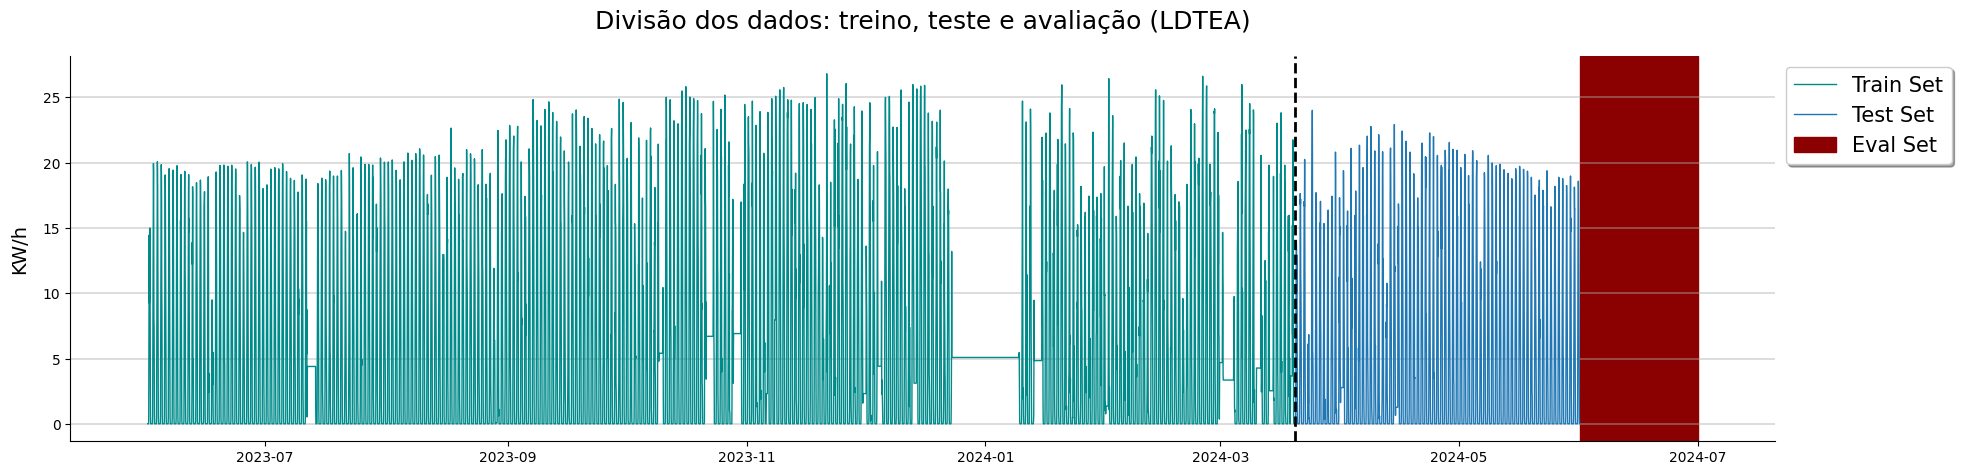

In [7]:
plt.figure(figsize=(22, 5))
plt.plot(df_train.index, df_train[TARGET], lw=1, color=color_train, label="Train Set")
plt.plot(df_test.index, df_test[TARGET], lw=1, color=color_test, label="Test Set")
plt.plot(df_eval.index, df_eval[TARGET], lw=0)

plt.xlabel("")
plt.ylabel("KW/h", fontsize=14, labelpad=10)
plt.title("Divisão dos dados: treino, teste e avaliação (LDTEA)", fontsize=18, pad=20)

plt.axvline(df_train.index.max(), color="black", lw=2, linestyle="--")
plt.axvspan(SPLIT_DATE_EVAL, df_raw.index.max(), alpha=1, color=dark_red, label="Eval Set")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(axis="y", alpha=0.5, linewidth=1.2)

plt.legend(
    fontsize=15,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
plt.show()


In [8]:
# Modelo Naive Lag - Conjunto de teste

start_time = time.time()

df_pred = df_test[[TARGET]].rename(columns={TARGET: "test"}).copy()

naive_pred = df_base[[TARGET]].shift(24)
df_pred["naive_pred"] = df_pred.index.map(naive_pred[TARGET])

print_forecast_accuracy(df_pred["test"], df_pred["naive_pred"], df_test[TARGET], "Naive Lag")

elapsed_time = time.time() - start_time
print(f"Tempo de execução: {elapsed_time:.2f} segundos")


                            Resumo das métricas de precisão (forecast accuracy - Naive Lag)                             
------------------------------------------------------------------------------------------------------------------------
Métrica |  24h   | (dia)  | Descrição                                         
------------------------------------------------------------------------------------------------------------------------
MAE     | ( 1.31 -  2.30) | As previsões, em média, estão (1.31 - 2.30) unidades distantes dos valores reais.
RMSE    | ( 2.89 -  3.89) | O erro médio do seu modelo é de (2.89 - 3.89) unidades em relação aos valores observados.
R²      | ( 0.82 -  0.69) | O coeficiente de determinação R² é (82.06% - 82.06%).
MSE     | ( 8.35 - 15.12) | A média dos quadrados das diferenças entre os valores previstos e reais é (8.35 - 8.35)
MAPE    | ( 0.70 -  0.69) | As previsões, em média, estão desviando em (69.92% - 69.92%) dos valores reais.
MASE    | ( 1.27 -  1.23

In [9]:
# Salvar metricas em arquivo .csv

metrics = calculate_forecast_accuracy(df_pred["test"], df_pred["naive_pred"], df_test[TARGET])
now = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
metrics = {k: round(v, 3) for k, v in metrics.items()}

metadata={
    "time": round(elapsed_time, 4), 
    "dataset": "test", 
    "features" : "naive lag",
    "date_exp": now
}
save_score_metrics(metrics, "naive", metadata=metadata)

Métricas salvas com sucesso em: /home/vieira/unb/tcc/repos/sige-ai/data/results/baseline/naive.csv


In [10]:
# Modelo Naive Mean - Conjunto de teste


start_time = time.time()

hour_mean = df_train.groupby(df_train.index.hour)[TARGET].mean()
df_pred["mean_pred"] = df_pred.index.hour.map(hour_mean)

print_forecast_accuracy(df_pred["test"], df_pred["mean_pred"], df_train[TARGET], "Naive Mean")

elapsed_time = time.time() - start_time
print(f"Tempo de execução: {elapsed_time:.2f} segundos")


                            Resumo das métricas de precisão (forecast accuracy - Naive Mean)                            
------------------------------------------------------------------------------------------------------------------------
Métrica |  24h   | (dia)  | Descrição                                         
------------------------------------------------------------------------------------------------------------------------
MAE     | ( 1.45 -  2.14) | As previsões, em média, estão (1.45 - 2.14) unidades distantes dos valores reais.
RMSE    | ( 2.29 -  3.05) | O erro médio do seu modelo é de (2.29 - 3.05) unidades em relação aos valores observados.
R²      | ( 0.89 -  0.81) | O coeficiente de determinação R² é (88.72% - 88.72%).
MSE     | ( 5.25 -  9.32) | A média dos quadrados das diferenças entre os valores previstos e reais é (5.25 - 5.25)
MAPE    | ( 1.65 -  1.68) | As previsões, em média, estão desviando em (165.44% - 165.44%) dos valores reais.
MASE    | ( 1.33 -  1.

In [11]:
# Salvar metricas em arquivo .csv

metrics = calculate_forecast_accuracy(df_pred["test"], df_pred["mean_pred"], df_test[TARGET])
now = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
metrics = {k: round(v, 3) for k, v in metrics.items()}

metadata={
    "time": round(elapsed_time, 4), 
    "dataset": "test", 
    "features" : "naive mean",
    "date_exp": now
}
save_score_metrics(metrics, "naive", metadata=metadata)

Métricas salvas com sucesso em: /home/vieira/unb/tcc/repos/sige-ai/data/results/baseline/naive.csv


In [12]:
# Modelo Naive Median - Conjunto de teste

start_time = time.time()

hour_median = df_train.groupby(df_train.index.hour)[TARGET].median()
df_pred["median_pred"] = df_pred.index.hour.map(hour_median)

display(df_pred.head(3))
print_forecast_accuracy(df_pred["test"], df_pred["median_pred"], df_test[TARGET], "Naive Median")

elapsed_time = time.time() - start_time
print(f"Tempo de execução: {elapsed_time:.2f} segundos")


test  naive_pred  mean_pred  median_pred
date_time                                                          
2024-03-20 00:00:00-03:00   0.0        3.66   0.599386          0.0
2024-03-20 01:00:00-03:00   0.0        3.66   0.601365          0.0
2024-03-20 02:00:00-03:00   0.0        3.66   0.601365          0.0

                           Resumo das métricas de precisão (forecast accuracy - Naive Median)                           
------------------------------------------------------------------------------------------------------------------------
Métrica |  24h   | (dia)  | Descrição                                         
------------------------------------------------------------------------------------------------------------------------
MAE     | ( 1.09 -  1.96) | As previsões, em média, estão (1.09 - 1.96) unidades distantes dos valores reais.
RMSE    | ( 2.35 -  3.18) | O erro médio do seu modelo é de (2.35 - 3.18) unidades em relação aos valores observados.
R²      | ( 0.88 -  0.79) | O coeficiente de determinação R² é (88.12% - 88.12%).
MSE     | ( 5.53 - 10.10) | A média dos quadrados das diferenças entre os valores previstos e reais é (5.53 - 5.53)
MAPE    | ( 1.01 -  1.01) | As previsões, em média, estão desviando em (100.69% - 100.69%) dos valores reais.
MASE    | ( 1.05 -  1.

In [13]:
# Salvar metricas em arquivo .csv

metrics = calculate_forecast_accuracy(df_pred["test"], df_pred["median_pred"], df_test[TARGET])
now = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
metrics = {k: round(v, 3) for k, v in metrics.items()}

metadata={
    "time": round(elapsed_time, 4), 
    "dataset": "test", 
    "features" : "naive median",
    "date_exp": now
}
save_score_metrics(metrics, "naive", metadata=metadata)

Métricas salvas com sucesso em: /home/vieira/unb/tcc/repos/sige-ai/data/results/baseline/naive.csv


---
### Desempenho dos modelos (Forecast Accuracy)

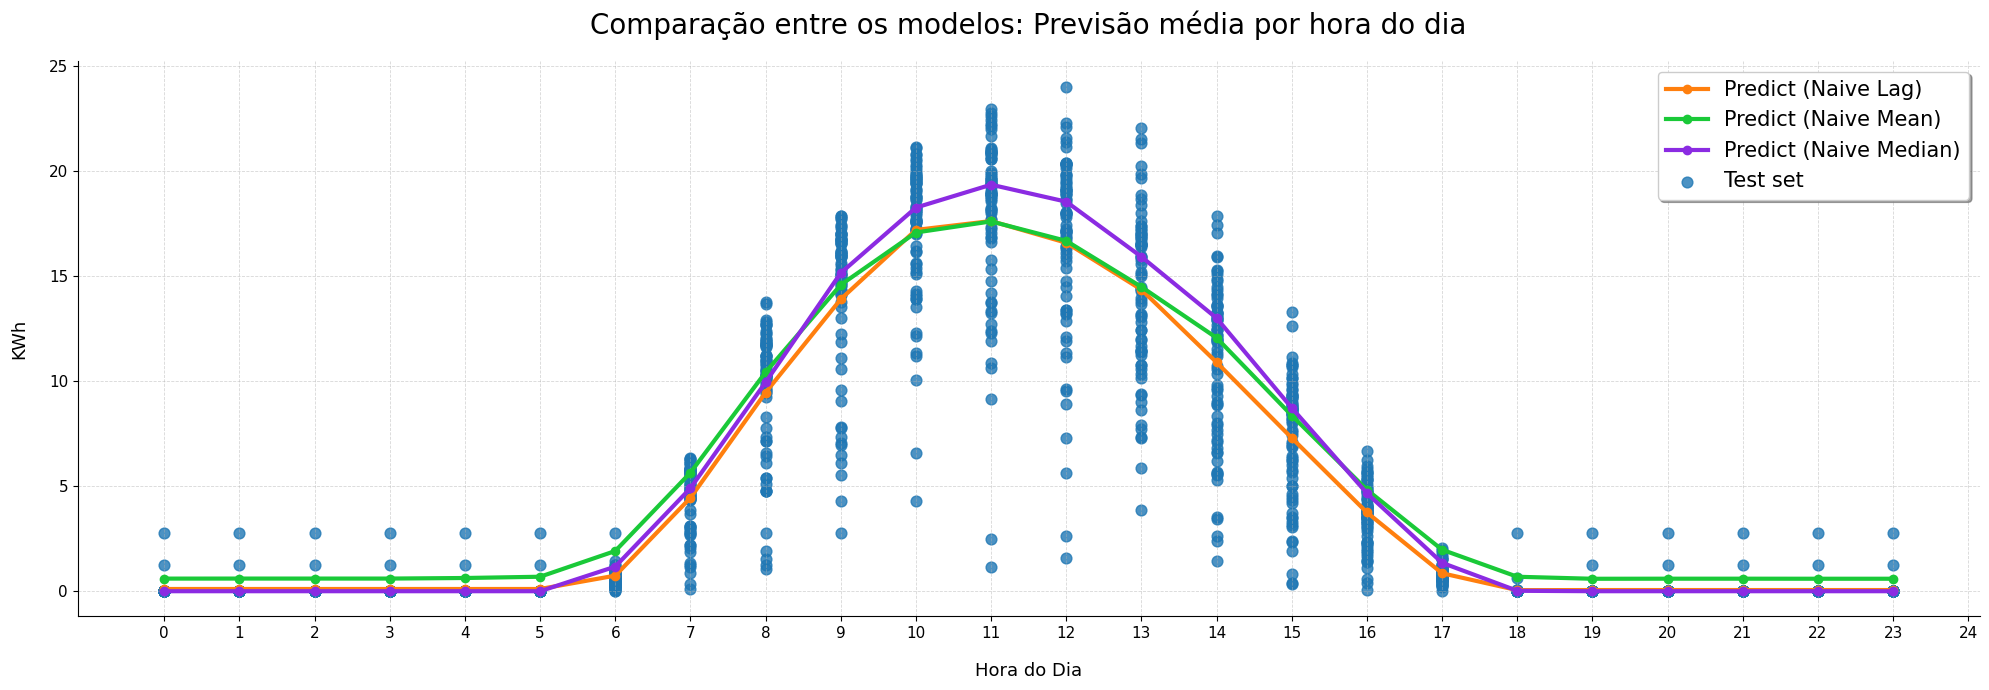

In [14]:
mean_pred = df_pred.groupby(df_pred.index.hour).mean()
colors = sns.color_palette("bright")

plt.figure(figsize=(20, 7))

predictions = [
    ("Predict (Naive Lag)", "naive_pred", color_forecast, 3),
    ("Predict (Naive Mean)", "mean_pred", colors[2], 3),
    ("Predict (Naive Median)", "median_pred", colors[4], 3),
]

for label, pred_col, color, lw in predictions:
    plt.plot(
        mean_pred.index,
        mean_pred[pred_col],
        label=label,
        color=color,
        lw=lw,
        marker="o",
    )
plt.scatter(
    df_test.index.hour,
    df_test[TARGET],
    label="Test set",
    color=color_test,
    s=60,
    alpha=0.8,
)

plt.title("Comparação entre os modelos: Previsão média por hora do dia", fontsize=20, pad=20)
plt.xlabel("Hora do Dia", fontsize=13, labelpad=15)
plt.ylabel("KWh", fontsize=13, labelpad=15)
plt.grid(True, linestyle="--", alpha=0.5, lw=0.6)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.xticks(np.arange(0, 25))
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(
    fontsize=15,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
)
plt.tight_layout()
plt.show()


In [15]:
df_score = pd.DataFrame()

colors = sns.color_palette("bright")

df_score["Naive Lag"] = calculate_forecast_accuracy(df_pred["test"], df_pred["naive_pred"], df_train[TARGET])
df_score["Naive Mean"] = calculate_forecast_accuracy(df_pred["test"], df_pred["mean_pred"], df_train[TARGET])
df_score["Naive Median"] = calculate_forecast_accuracy(df_pred["test"], df_pred["median_pred"], df_train[TARGET])

df_score = df_score.T
df_score = df_score.round(2)
df_score.sort_values(by=["mae", "mse", "rmse"], inplace=True)
df_score.head(7)



mae  rmse   mse    r2  mape  mase  mae_day  rmse_day  mse_day  \
Naive Median  1.09  2.35  5.53  0.88  1.01  1.00     1.96      3.18    10.10   
Naive Lag     1.31  2.89  8.35  0.82  0.70  1.20     2.30      3.89    15.12   
Naive Mean    1.45  2.29  5.25  0.89  1.65  1.33     2.14      3.05     9.32   

              r2_day  mape_day  mase_day  
Naive Median    0.79      1.01      1.00  
Naive Lag       0.69      0.69      1.17  
Naive Mean      0.81      1.68      1.09

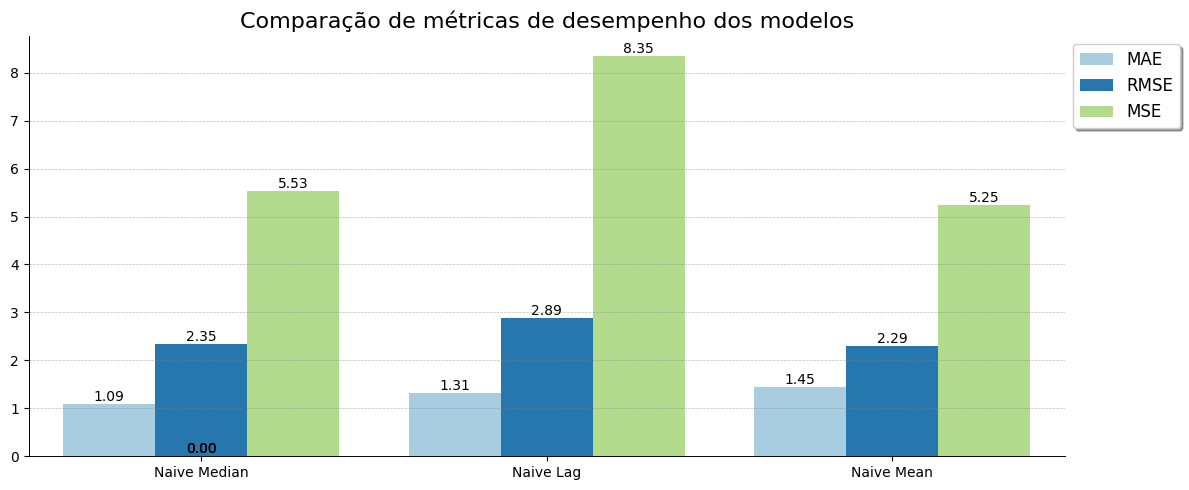

In [16]:
df_plot = (
    df_score[["mae", "rmse", "mse"]]
    .reset_index()
    .melt(
        id_vars="index",
        var_name="metric",
        value_name="value",
    )
)
df_plot["metric"] = df_plot["metric"].str.upper()

fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(
    data=df_plot,
    x="index",
    y="value",
    hue="metric",
    width=0.8,
    palette="Paired",
    saturation=0.9,
    dodge=True, 
)

ax.set_title("Comparação de métricas de desempenho dos modelos", fontsize=16)
ax.set_xlabel("")
ax.set_ylabel("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.7)
ax.spines["bottom"].set_linewidth(0.7)
ax.yaxis.grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.5)

plt.xticks(rotation=0, ha="center", fontsize=10)
plt.yticks(fontsize=10)

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10,
        color="black",
    )

plt.legend(
    loc="upper left",
    fontsize=12,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
plt.tight_layout()
plt.show()


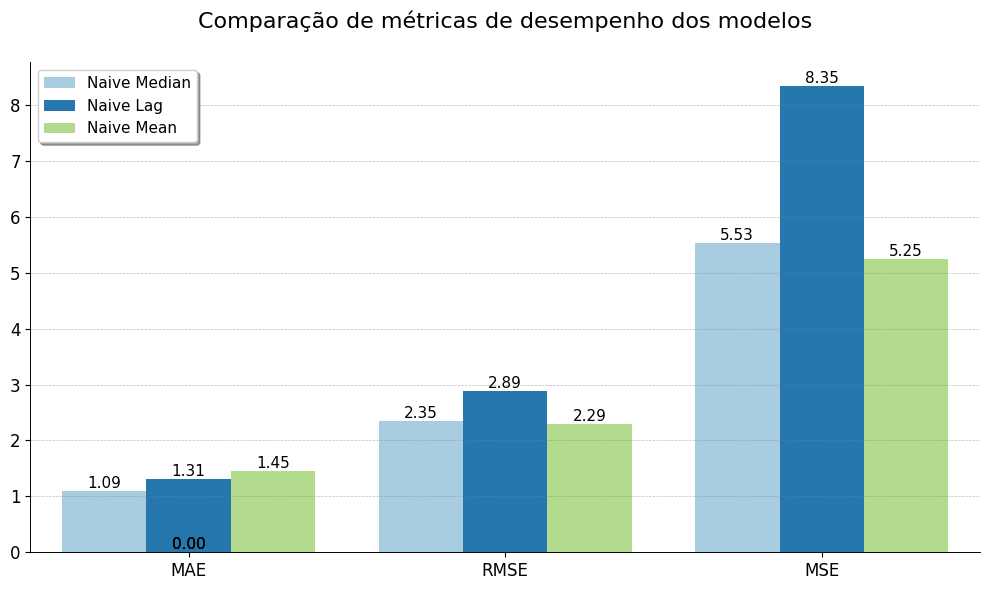

In [17]:

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=df_plot,
    x="metric",
    y="value",
    hue="index",
    width=0.8,
    palette="Paired",
    saturation=0.9,
    dodge=True, 
)

ax.set_title("Comparação de métricas de desempenho dos modelos", fontsize=16, pad=25)
ax.set_xlabel("")
ax.set_ylabel("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.7)
ax.spines["bottom"].set_linewidth(0.7)
ax.yaxis.grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.5)

plt.xticks(rotation=0, ha="center", fontsize=12)
plt.yticks(fontsize=12)

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=11,
        color="black",
    )

plt.legend(
    loc="upper left",
    fontsize=11,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
)
plt.tight_layout()
plt.show()


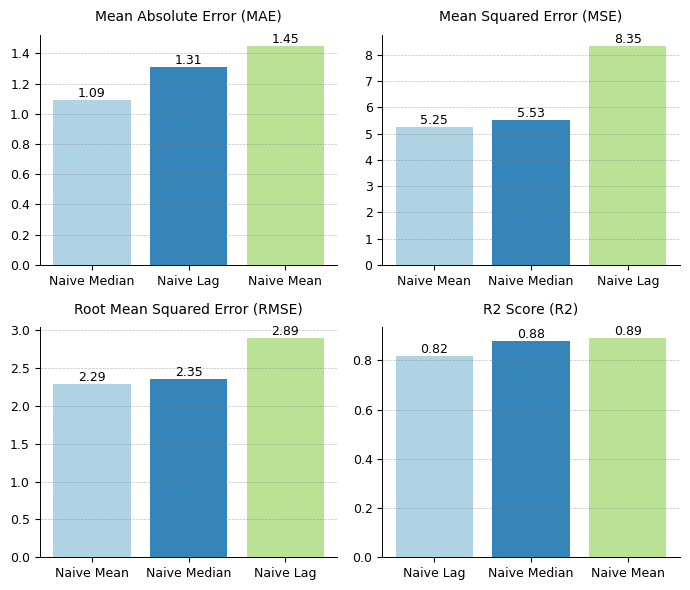

In [18]:
df_plot = (
    df_score[["mae", "mse", "rmse", "r2"]]
    .reset_index()
    .melt(
        id_vars="index",
        var_name="metric",
        value_name="value",
    )
)

colors = sns.color_palette("Paired")

fig, axes = plt.subplots(2, 2, figsize=(7, 6))

metrics = df_plot["metric"].unique()
for i, j in itertools.product(range(2), range(2)):
    metric = metrics[i * 2 + j]
    ax = axes[i, j]
    df_group = df_plot[df_plot["metric"] == metric].copy()
    df_group.sort_values("value", ascending=True, inplace=True)

    ax.bar(
        df_group["index"],
        df_group["value"],
        color=colors,
        alpha=0.9,
    )

    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="bottom",
            fontsize=9,
            color="black",
        )

    ax.set_title(f"{mapping_metrics[metric]} ({metric.upper()})", fontsize=10, pad=10)
    ax.tick_params(axis="x", labelsize=9)
    ax.tick_params(axis="y", labelsize=9)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(0.7)
    ax.spines["bottom"].set_linewidth(0.7)
    ax.yaxis.grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.5)

plt.tight_layout()
plt.show()


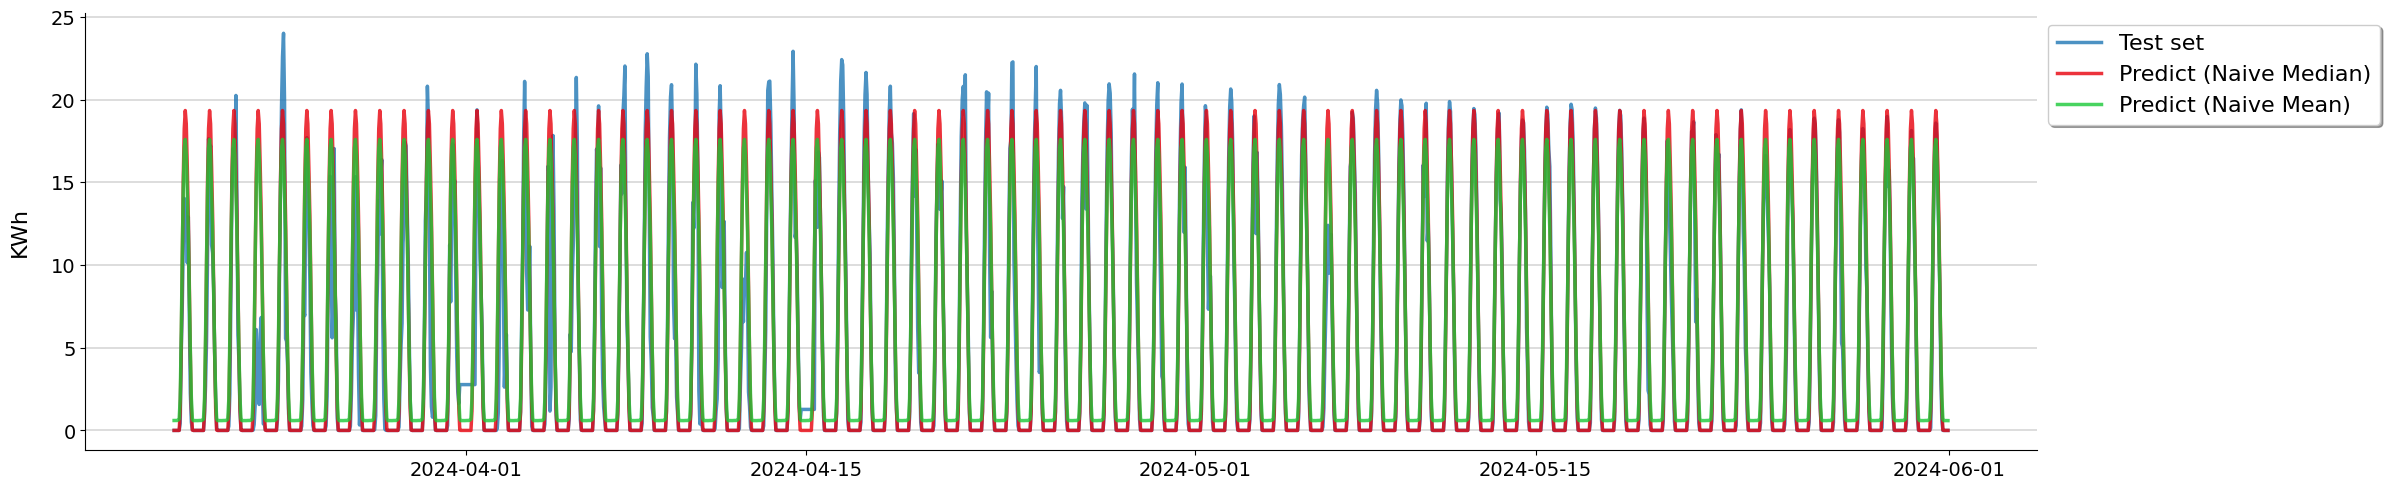

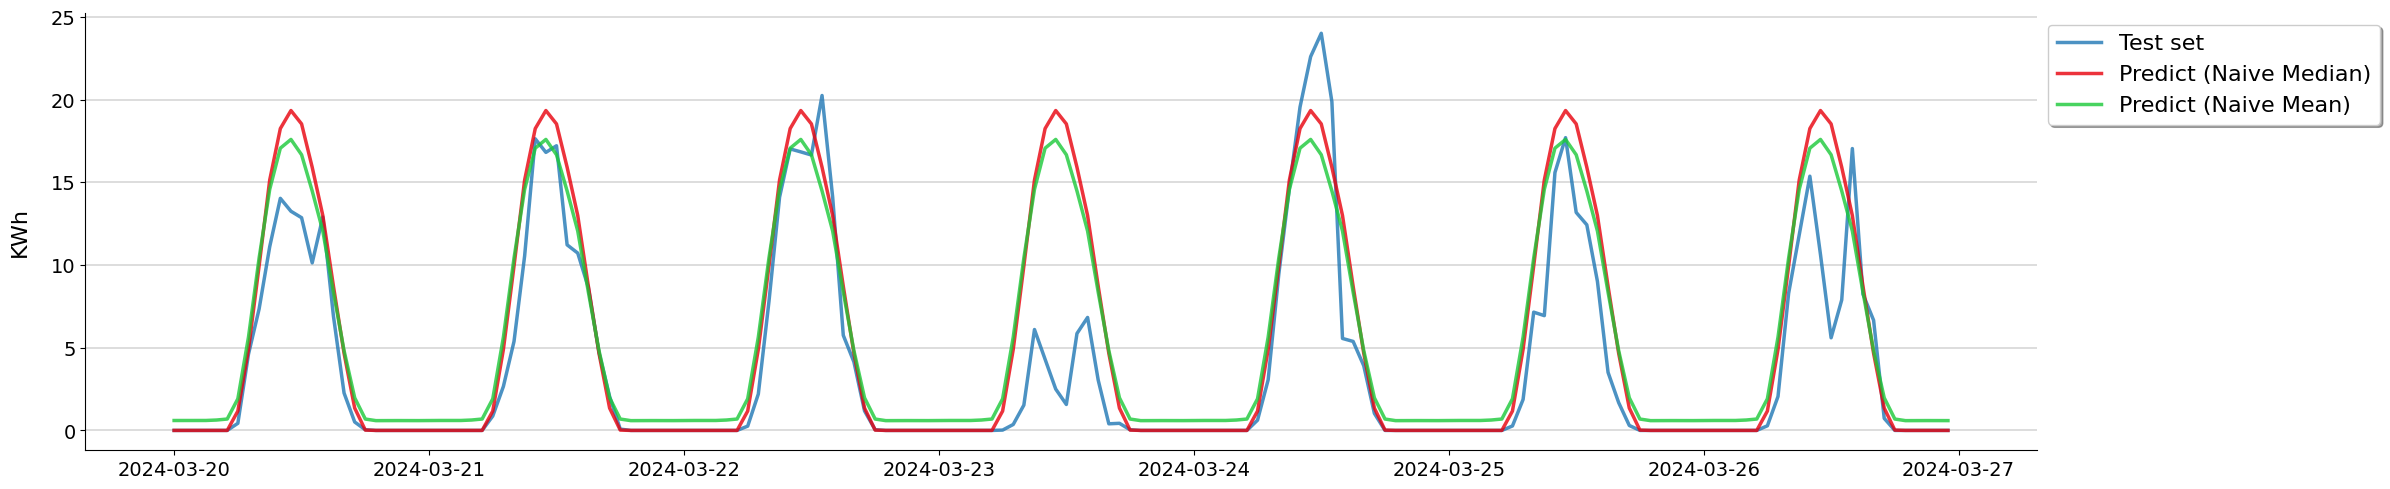

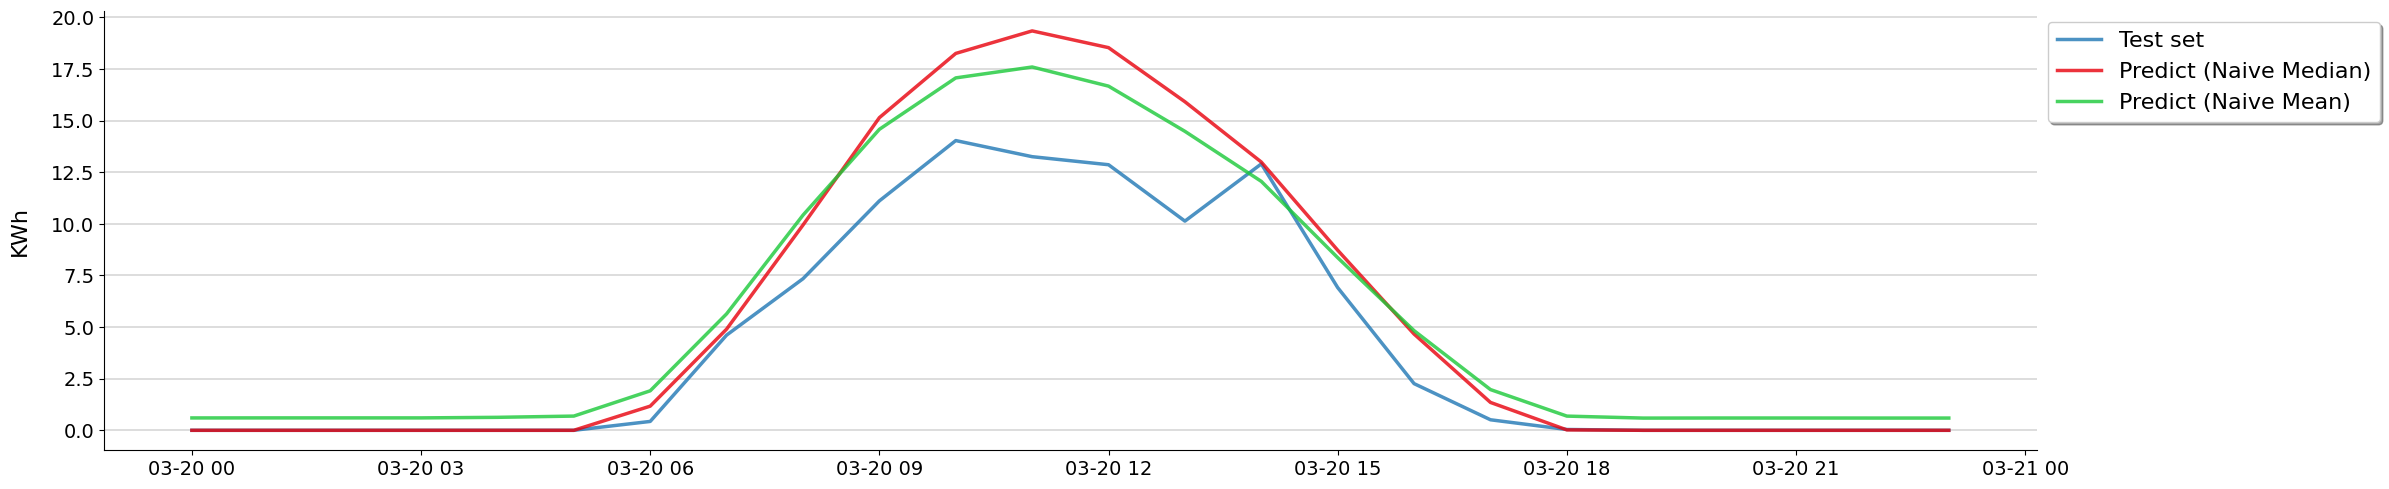

In [19]:
# Plotar previsao de energia (LDTEA) no conjunto de teste

df_plot = pd.concat([df_train[TARGET], df_pred], axis="columns")
df_plot.rename(columns={TARGET: "train"}, inplace=True)

plot_forecast(df_plot[["train", "test", "median_pred", "mean_pred"]], "predict_full", span=False)

start = df_train.index.max() - pd.DateOffset(days=0)
end = start + pd.DateOffset(days=7)
plot_forecast(df_plot[["test", "median_pred", "mean_pred"]], "predict_seven", start, end, span=False)

start = df_train.index.max() - pd.DateOffset(days=0)
end = start + pd.DateOffset(days=1)
plot_forecast(df_plot[["test", "median_pred", "mean_pred"]], "predict_one", start, end, span=False)



--------
#### Previsao do futuro usando Naive Median
 - Retreinar com todos os dados disponiveis de treino e teste.

---



In [20]:
# Model Naive Lag - Conjunto avaliacao
fc_pred = df_eval[[TARGET]].copy()
df_temp = pd.concat([df_base.tail(24), df_eval], axis="rows")
fc_pred["lag_pred"] = df_temp[[TARGET]].shift(24)

In [21]:
start_time = time.time()

# Model Naive Median - Conjunto de avaliação 
hour_median = df_base.groupby(df_base.index.hour)[TARGET].median()
fc_pred["median_pred"] = fc_pred.index.hour.map(hour_median)

elapsed_time = time.time() - start_time
print(f"Tempo de execução: {elapsed_time:.2f} segundos")

# Model Naive Mean - Conjunto de avaliação 
hour_mean = df_base.groupby(df_base.index.hour)[TARGET].mean()
fc_pred["mean_pred"] = fc_pred.index.hour.map(hour_mean)

# renomear o melhor modelo naive
fc_pred.rename(columns={"median_pred": "y_pred"}, inplace=True) 


Tempo de execução: 0.00 segundos


In [22]:
fc_pred_fd = fc_pred.head(24).copy()
print_forecast_accuracy(fc_pred_fd[TARGET], fc_pred_fd["y_pred"], df_base[TARGET], "Naive Median")


                           Resumo das métricas de precisão (forecast accuracy - Naive Median)                           
------------------------------------------------------------------------------------------------------------------------
Métrica |  24h   | (dia)  | Descrição                                         
------------------------------------------------------------------------------------------------------------------------
MAE     | ( 1.02 -  1.88) | As previsões, em média, estão (1.02 - 1.88) unidades distantes dos valores reais.
RMSE    | ( 1.95 -  2.65) | O erro médio do seu modelo é de (1.95 - 2.65) unidades em relação aos valores observados.
R²      | ( 0.89 -  0.81) | O coeficiente de determinação R² é (89.48% - 89.48%).
MSE     | ( 3.80 -  7.01) | A média dos quadrados das diferenças entre os valores previstos e reais é (3.80 - 3.80)
MAPE    | ( 0.42 -  0.42) | As previsões, em média, estão desviando em (41.73% - 41.73%) dos valores reais.
MASE    | ( 1.00 -  1.00

In [23]:
# Salvar metricas em arquivo .csv

metrics = calculate_forecast_accuracy(fc_pred_fd[TARGET], fc_pred_fd["y_pred"], df_base[TARGET])
now = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
metrics = {k: round(v, 3) for k, v in metrics.items()}

metadata={
    "time": round(elapsed_time, 4), 
    "dataset": "eval24", 
    "features" : "naive median",
    "date_exp": now
}
save_score_metrics(metrics, "naive", metadata=metadata)

Métricas salvas com sucesso em: /home/vieira/unb/tcc/repos/sige-ai/data/results/baseline/naive.csv


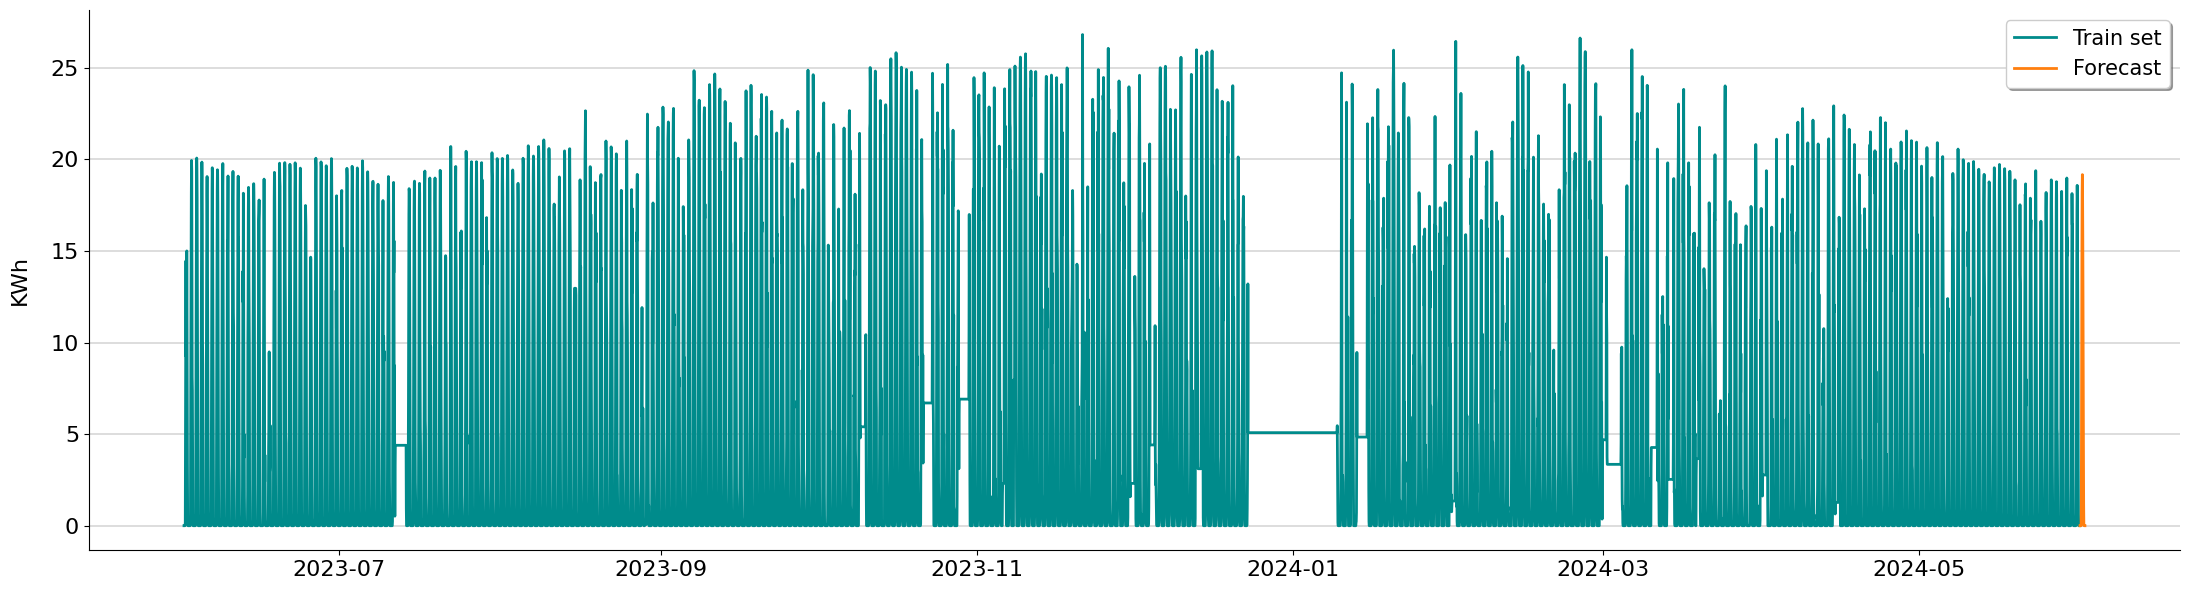

In [24]:
plt.figure(figsize=(22, 6))

plt.plot(df_base.index, df_base, label="Train set", color=color_train, lw=2)
plt.plot(fc_pred_fd.index, fc_pred_fd["y_pred"], label="Forecast", color=color_future, lw=2)

# plt.title("LDTEA - Naive Forecast 24 steps", fontsize=20, fontweight="bold", pad=20)
plt.ylabel("KWh", fontsize=16, labelpad=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(axis="y", alpha=0.5, linewidth=1.2)

plt.legend(
    fontsize=15,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
plt.tight_layout()
if SAVE_PLOT:
    plt.savefig("../figures/naive/forecast_full_24h.pdf", dpi=300)
    plt.savefig("../figures/naive/forecast_full_24h.svg", dpi=300)
plt.show()




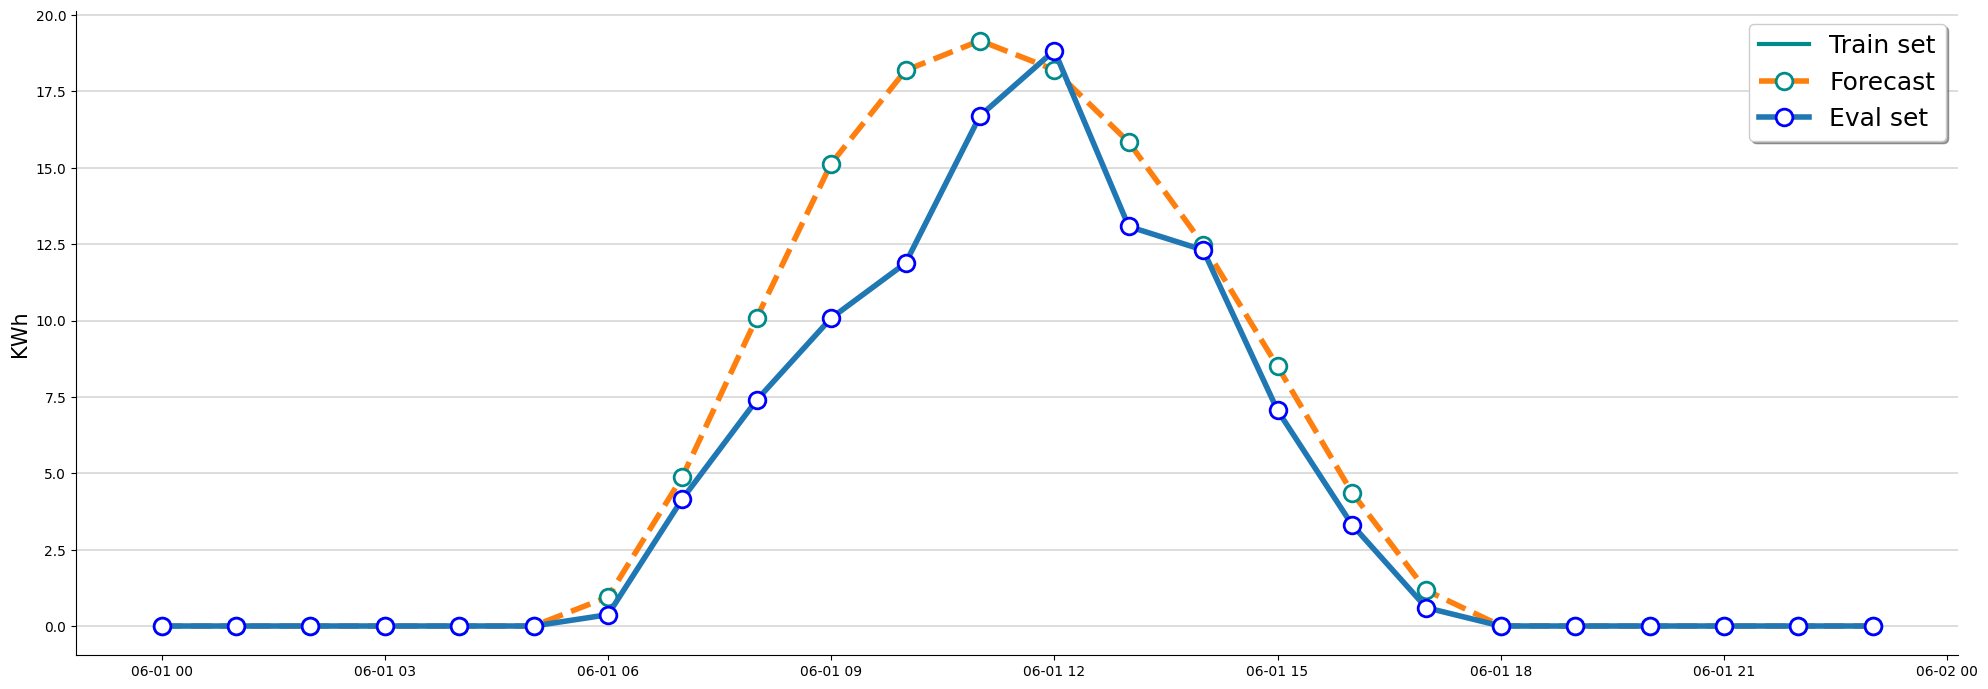

In [25]:
index_min = df_base.index.max()
df_lm = df_base[df_base.index > index_min]

plt.figure(figsize=(20, 7))

plt.plot(
    df_lm.index,
    df_lm,
    label="Train set",
    color=color_train,
    lw=3,
)

plt.plot(
    fc_pred_fd.index,
    fc_pred_fd["y_pred"],
    label="Forecast",
    color=color_future,
    marker="o",
    ls="--",
    lw=4,
    markersize=12,
    markerfacecolor="white",
    markeredgewidth=2,
    markeredgecolor=dark_cyan,
)

plt.plot(
    fc_pred.loc[fc_pred_fd.index].index,
    fc_pred.loc[fc_pred_fd.index][TARGET],
    label="Eval set",
    color=color_test,
    marker="o",
    lw=4,
    markersize=12,
    markerfacecolor="white",
    markeredgecolor="blue",
    markeredgewidth=2,
)

# plt.title("LDTEA - Naive Forecast 24 steps", fontsize=18)
plt.ylabel("KWh", fontsize=15)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(axis="y", alpha=0.5, linewidth=1.2)
plt.legend(
    fontsize=18,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
if SAVE_PLOT:
    plt.savefig("../figures/naive/forecast_od.pdf", dpi=300)
    plt.savefig("../figures/naive/forecast_od.svg", dpi=300)
    
plt.tight_layout()
plt.show()

In [26]:
print_forecast_accuracy(fc_pred[TARGET], fc_pred["y_pred"], df_base[TARGET], "Naive Median")
print(f"Tempo de execução: {elapsed_time:.2f} segundos")


# Salvar metricas em arquivo .csv

metrics = calculate_forecast_accuracy(fc_pred[TARGET], fc_pred["y_pred"], df_base[TARGET])
now = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
metrics = {k: round(v, 3) for k, v in metrics.items()}

metadata={
    "time": round(elapsed_time, 4), 
    "dataset": "eval168",
    "features" : "naive median",
    "date_exp": now
}
save_score_metrics(metrics, "naive", metadata=metadata)

                           Resumo das métricas de precisão (forecast accuracy - Naive Median)                           
------------------------------------------------------------------------------------------------------------------------
Métrica |  24h   | (dia)  | Descrição                                         
------------------------------------------------------------------------------------------------------------------------
MAE     | ( 1.26 -  1.95) | As previsões, em média, estão (1.26 - 1.95) unidades distantes dos valores reais.
RMSE    | ( 2.60 -  3.32) | O erro médio do seu modelo é de (2.60 - 3.32) unidades em relação aos valores observados.
R²      | ( 0.81 -  0.71) | O coeficiente de determinação R² é (81.33% - 81.33%).
MSE     | ( 6.75 - 11.00) | A média dos quadrados das diferenças entre os valores previstos e reais é (6.75 - 6.75)
MAPE    | ( 0.69 -  0.66) | As previsões, em média, estão desviando em (69.49% - 69.49%) dos valores reais.
MASE    | ( 1.00 -  1.00

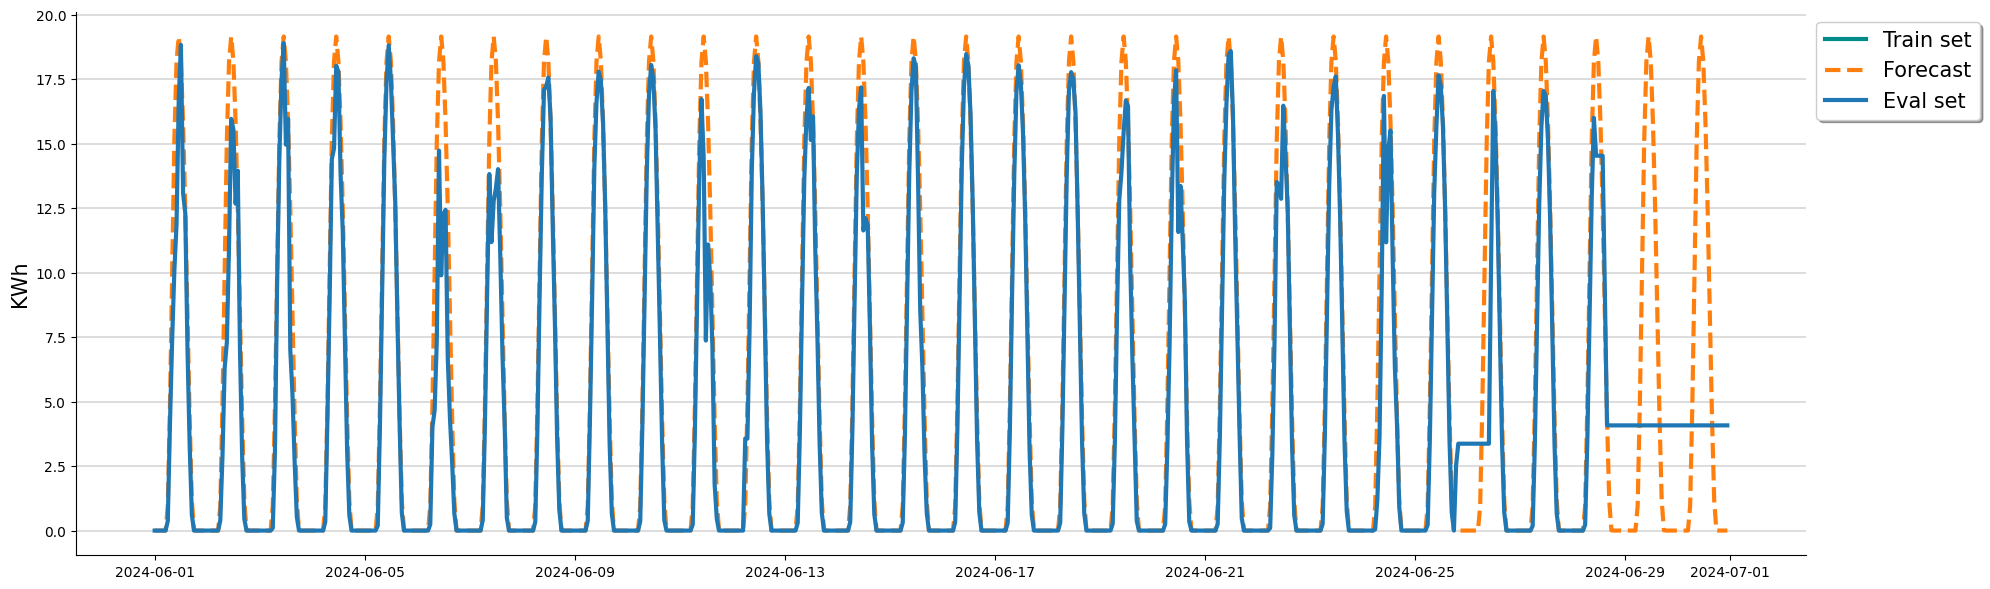

In [27]:
index_min = df_base.index.max()
df_lm = df_base[df_base.index > index_min]

plt.figure(figsize=(20, 6))

plt.plot(
    df_lm.index,
    df_lm,
    label="Train set",
    color=color_train,
    lw=3,
)

plt.plot(
    fc_pred.index,
    fc_pred["y_pred"],
    label="Forecast",
    color=color_future,
    lw=3,
    linestyle="--",
)

plt.plot(
    fc_pred.index,
    fc_pred[TARGET],
    label="Eval set",
    color=color_test,
    lw=3,
)

# plt.title("LDTEA - Naive Forecast 144 steps", fontsize=18)
plt.ylabel("KWh", fontsize=15)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(axis="y", alpha=0.5, linewidth=1.2)
plt.legend(
    fontsize=15,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
if SAVE_PLOT:
    plt.savefig("../figures/naive/forecast_sd.pdf", dpi=300)
    plt.savefig("../figures/naive/forecast_sd.svg", dpi=300)
plt.tight_layout()
plt.show()

----

In [28]:
fc_pred["error"] = fc_pred[TARGET] - fc_pred["y_pred"]
fc_pred["abs_error"] = np.abs(fc_pred["error"])
fc_pred.head()

ldtea_avg  lag_pred  y_pred  mean_pred  error  \
date_time                                                                  
2024-06-01 00:00:00-03:00        0.0       0.0     0.0   0.490874    0.0   
2024-06-01 01:00:00-03:00        0.0       0.0     0.0   0.492459    0.0   
2024-06-01 02:00:00-03:00        0.0       0.0     0.0   0.492459    0.0   
2024-06-01 03:00:00-03:00        0.0       0.0     0.0   0.492459    0.0   
2024-06-01 04:00:00-03:00        0.0       0.0     0.0   0.514208    0.0   

                           abs_error  
date_time                             
2024-06-01 00:00:00-03:00        0.0  
2024-06-01 01:00:00-03:00        0.0  
2024-06-01 02:00:00-03:00        0.0  
2024-06-01 03:00:00-03:00        0.0  
2024-06-01 04:00:00-03:00        0.0

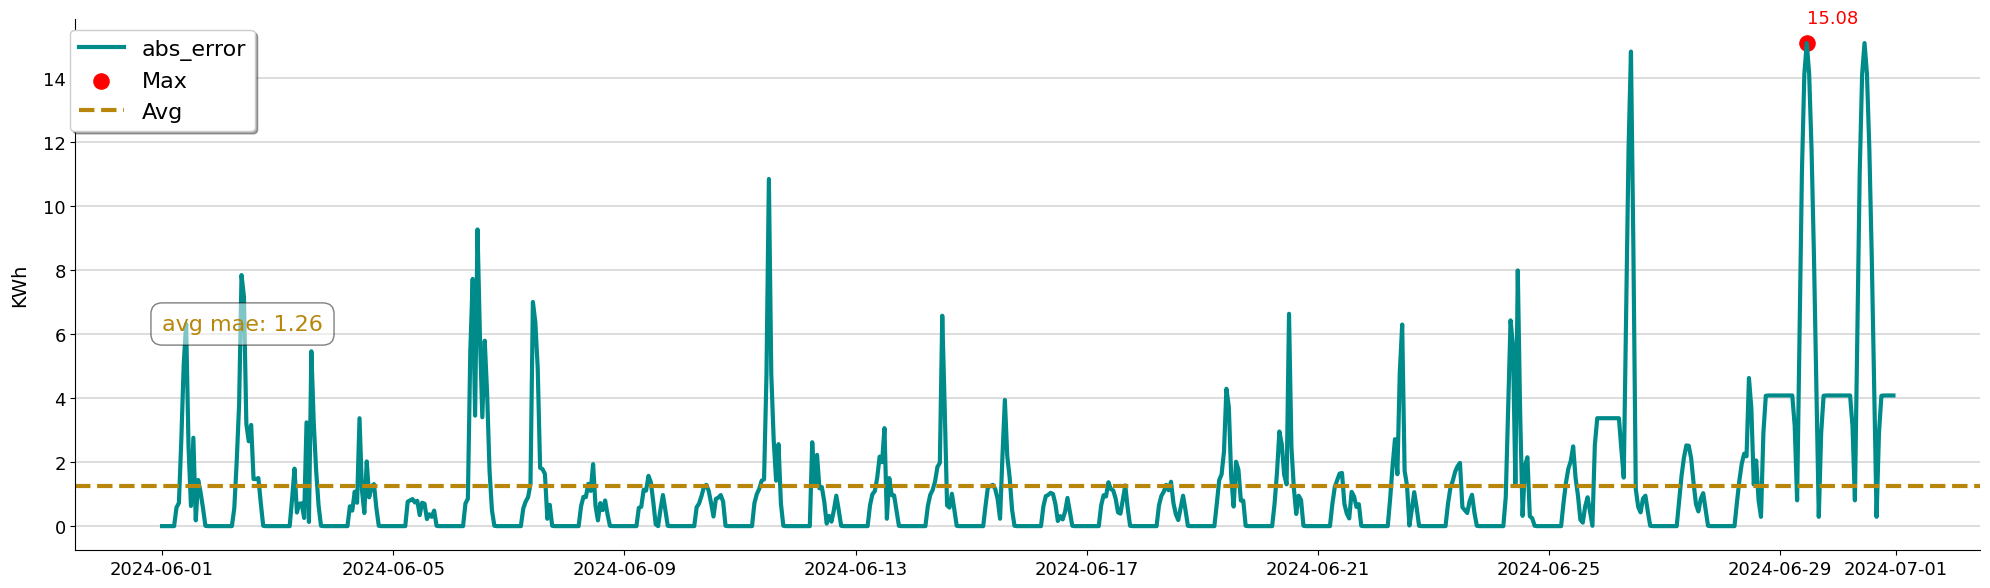

In [29]:
# Plotar mean_absolute_error

idx_max = fc_pred["abs_error"].idxmax()
idx_min = fc_pred["abs_error"].idxmin()
point_max = fc_pred.loc[idx_max]
point_min = fc_pred.loc[idx_min]

avg_mae = fc_pred["abs_error"].mean()

plt.figure(figsize=(20, 6))
plt.plot(fc_pred.index, fc_pred["abs_error"], lw=3, color=color_train, label="abs_error")

plt.scatter(point_max.name, point_max["abs_error"], s=120, color="red", label="Max")
plt.axhline(avg_mae, lw=3, color=dark_golden_rod, ls="--", label="Avg")

plt.text(
    point_max.name,
    point_max["abs_error"] + 0.5,
    f"{point_max['abs_error']:.2f}",
    ha="left",
    va="bottom",
    fontsize=13,
    color="red",
)

plt.text(
    fc_pred.index.min(),
    6,
    f"avg mae: {avg_mae:.2f}",
    ha="left",
    va="bottom",
    fontsize=16,
    color=dark_golden_rod,
    bbox=dict(boxstyle="round", pad=0.5, facecolor="white", alpha=0.5),
)

# plt.title("Absolute Error - Naive Mean", fontsize=18, pad=20)
plt.xlabel("")
plt.ylabel("KWh", fontsize=14, labelpad=10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(axis="y", alpha=0.5, linewidth=1.2)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(
    fontsize=16,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(0.1, 1),
)
plt.tight_layout()
if SAVE_PLOT:
    plt.savefig("../figures/naive/abs_error.pdf", dpi=300)
    plt.savefig("../figures/naive/abs_error.svg", dpi=300)
plt.show()


In [30]:
fc_pred

ldtea_avg  lag_pred  y_pred  mean_pred  error  \
date_time                                                                  
2024-06-01 00:00:00-03:00       0.00      0.00     0.0   0.490874   0.00   
2024-06-01 01:00:00-03:00       0.00      0.00     0.0   0.492459   0.00   
2024-06-01 02:00:00-03:00       0.00      0.00     0.0   0.492459   0.00   
2024-06-01 03:00:00-03:00       0.00      0.00     0.0   0.492459   0.00   
2024-06-01 04:00:00-03:00       0.00      0.00     0.0   0.514208   0.00   
...                              ...       ...     ...        ...    ...   
2024-06-30 19:00:00-03:00       4.08      4.08     0.0   0.484754   4.08   
2024-06-30 20:00:00-03:00       4.08      4.08     0.0   0.487951   4.08   
2024-06-30 21:00:00-03:00       4.08      4.08     0.0   0.487951   4.08   
2024-06-30 22:00:00-03:00       4.08      4.08     0.0   0.486066   4.08   
2024-06-30 23:00:00-03:00       4.08      4.08     0.0   0.486066   4.08   

                           abs_error  
date_time                             
2024-06-01 00:00:00-03:00       0.00  
2024-06-01 01:00:00-03:00       0.00  
2024-06-01 02:00:00-03:00       0.00  
2024-06-01 03:00:00-03:00       0.00  
2024-06-01 04:00:00-03:00       0.00  
...                              ...  
2024-06-30 19:00:00-03:00       4.08  
2024-06-30 20:00:00-03:00       4.08  
2024-06-30 21:00:00-03:00       4.08  
2024-06-30 22:00:00-03:00       4.08  
2024-06-30 23:00:00-03:00       4.08  

[720 rows x 6 columns]

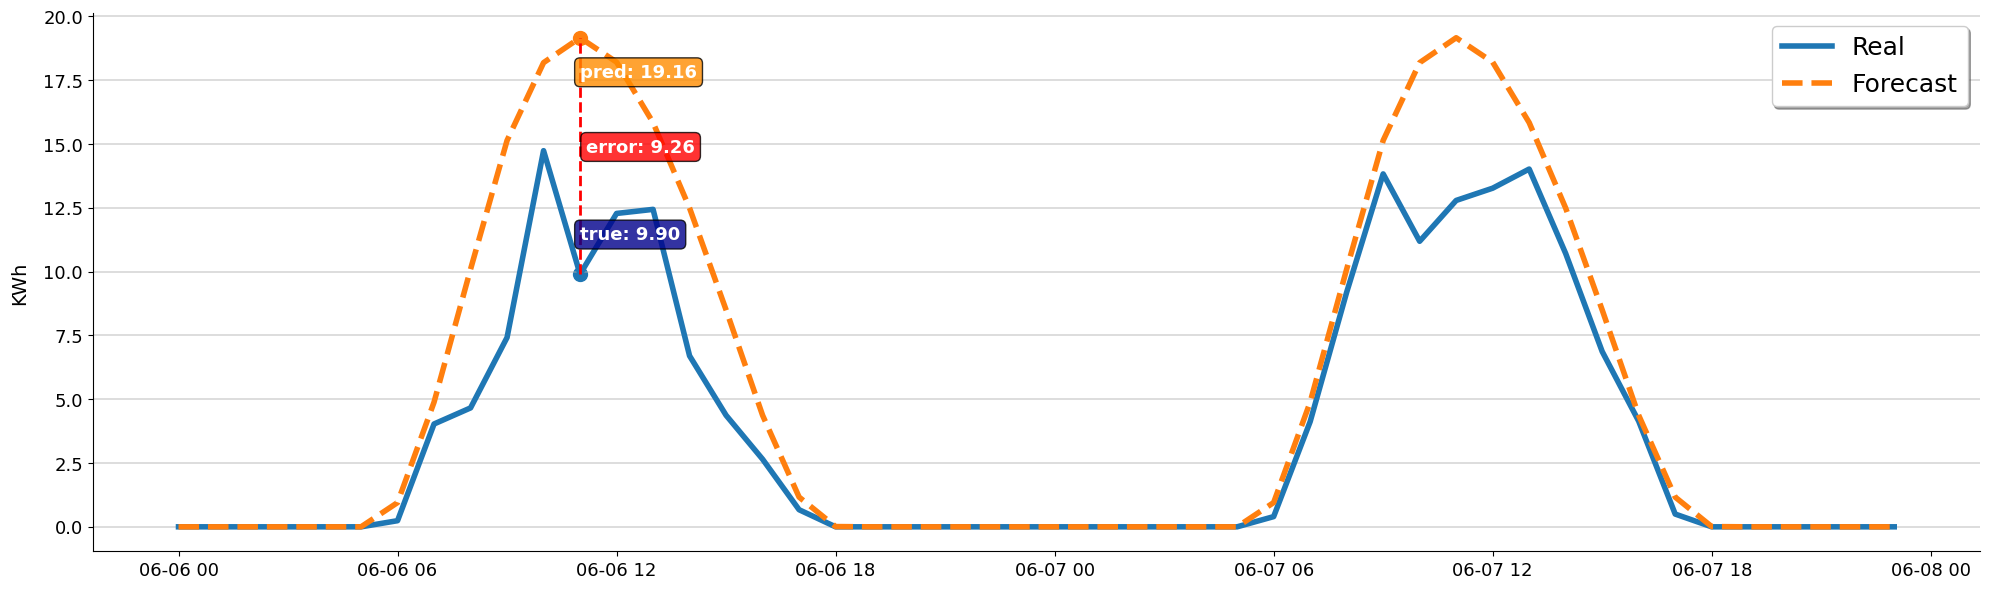

In [31]:
# plotar previsão e valor real para os dias 11 e 12 de Junho de 2024:
# Dias com grande erro de previsão devido oscilação na irradiação solar.

date_range = pd.date_range("2024-06-06", periods=48, freq="H", tz='America/Sao_Paulo')
df_filtered = fc_pred[fc_pred.index.isin(date_range)]

idx = df_filtered["abs_error"].idxmax()
point = df_filtered.loc[idx]

plt.figure(figsize=(20, 6))
plt.plot(df_filtered.index, df_filtered[TARGET], lw=4, color=color_test, label="Real")
plt.plot(df_filtered.index, df_filtered["y_pred"], lw=4, ls="--", color=color_forecast, label="Forecast")
plt.scatter(point.name, point[TARGET], color=color_test, s=100)
plt.scatter(point.name, point["y_pred"], color=color_forecast, s=100)
plt.vlines(point.name, point[TARGET], point["y_pred"], color="red", lw=2, linestyle="--")

plt.text(
    point.name,
    point[TARGET] + 1.2,
    f"true: {point[TARGET]:.2f}",
    ha="left",
    va="bottom",
    fontsize=13,
    color="white",
    fontweight="bold",
    bbox=dict(boxstyle="round", pad=.3, facecolor=dark_blue, alpha=0.8),
)

plt.text(
    point.name,
    point["y_pred"] - 1,
    f"pred: {point['y_pred']:.2f}",
    ha="left",
    va="top",
    fontsize=13,
    color="white",
    fontweight="bold",
    bbox=dict(boxstyle="round", pad=.3, facecolor=dark_orange, alpha=0.8),
)

plt.text(
    point.name + pd.DateOffset(minutes=10),
    (point[TARGET] + point['y_pred']) / 2,
    f"error: {point['abs_error']:.2f}",
    ha="left",
    va="bottom",
    fontsize=13,
    color="white",
    fontweight="bold",
    bbox=dict(boxstyle="round", pad=.3, facecolor="red", alpha=0.8),
)

# plt.title(f"Previsão de energia ({df_filtered.index.date.min()}) - LightGBM", fontsize=18, pad=30)
plt.xlabel("")
plt.ylabel("KWh", fontsize=14, labelpad=10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(axis="y", alpha=0.5, linewidth=1.2)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(
    fontsize=18,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
plt.tight_layout()
if SAVE_PLOT:
    plt.savefig("../figures/naive/forecast_error_11_06_24.pdf", dpi=300)
    plt.savefig("../figures/naive/forecast_error_11_06_24.svg", dpi=300)
plt.show()


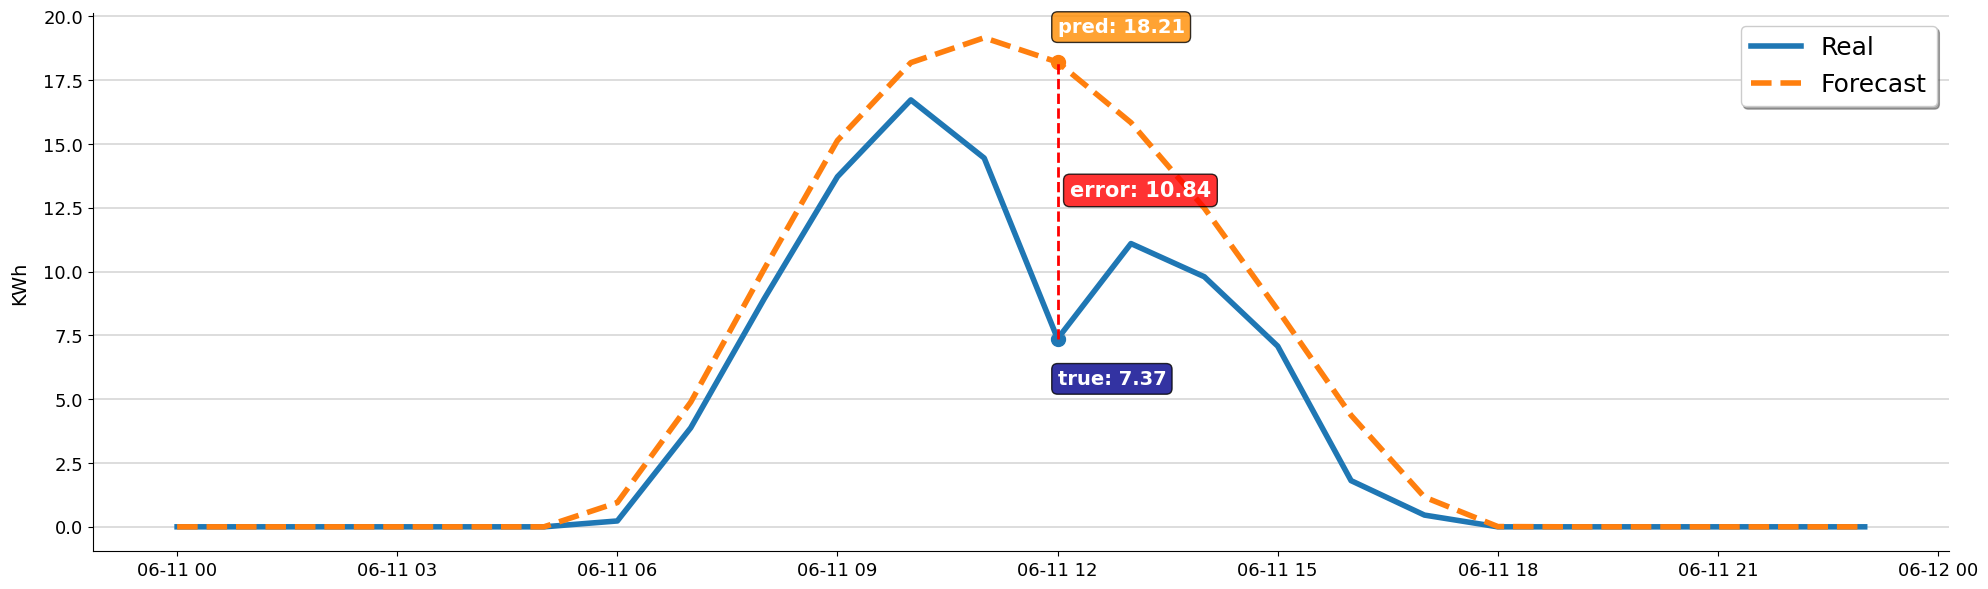

In [32]:
# plotar previsão e valor real para o dia 11 de Junho de 2024:
# Dia com grande erro de previsão devido oscilação na irradiação solar.

date_range = pd.date_range("2024-06-11", periods=24, freq="H", tz='America/Sao_Paulo')
df_filtered = fc_pred[fc_pred.index.isin(date_range)]

idx = df_filtered["abs_error"].idxmax()
point = df_filtered.loc[idx]

plt.figure(figsize=(20, 6))
plt.plot(df_filtered.index, df_filtered[TARGET], lw=4, color=color_test, label="Real")
plt.plot(df_filtered.index, df_filtered["y_pred"], lw=4, ls="--", color=color_forecast, label="Forecast")
plt.scatter(point.name, point[TARGET], color=color_test, s=100)
plt.scatter(point.name, point["y_pred"], color=color_forecast, s=100)
plt.vlines(point.name, point[TARGET], point["y_pred"], color="red", lw=2, linestyle="--")

plt.text(
    point.name,
    point[TARGET] - 1.2,
    f"true: {point[TARGET]:.2f}",
    ha="left",
    va="top",
    fontsize=14,
    color="white",
    fontweight="bold",
    bbox=dict(boxstyle="round", pad=.3, facecolor=dark_blue, alpha=0.8),
)

plt.text(
    point.name,
    point["y_pred"] + 1,
    f"pred: {point['y_pred']:.2f}",
    ha="left",
    va="bottom",
    fontsize=14,
    color="white",
    fontweight="bold",
    bbox=dict(boxstyle="round", pad=.3, facecolor=dark_orange, alpha=0.8),
)

plt.text(
    point.name + pd.DateOffset(minutes=10),
    (point[TARGET] + point['y_pred']) / 2,
    f"error: {point['abs_error']:.2f}",
    ha="left",
    va="bottom",
    fontsize=15,
    color="white",
    fontweight="bold",
    bbox=dict(boxstyle="round", pad=.3, facecolor="red", alpha=0.8),
)

# plt.title(f"Previsão de energia ({df_filtered.index.date.min()}) - Naive", fontsize=18, pad=30)
plt.xlabel("")
plt.ylabel("KWh", fontsize=14, labelpad=10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(axis="y", alpha=0.5, linewidth=1.2)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(
    fontsize=18,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
plt.tight_layout()
if SAVE_PLOT:
    plt.savefig("../figures/naive/forecast_error_11_06_24.pdf", dpi=300)
    plt.savefig("../figures/naive/forecast_error_11_06_24.svg", dpi=300)
plt.show()


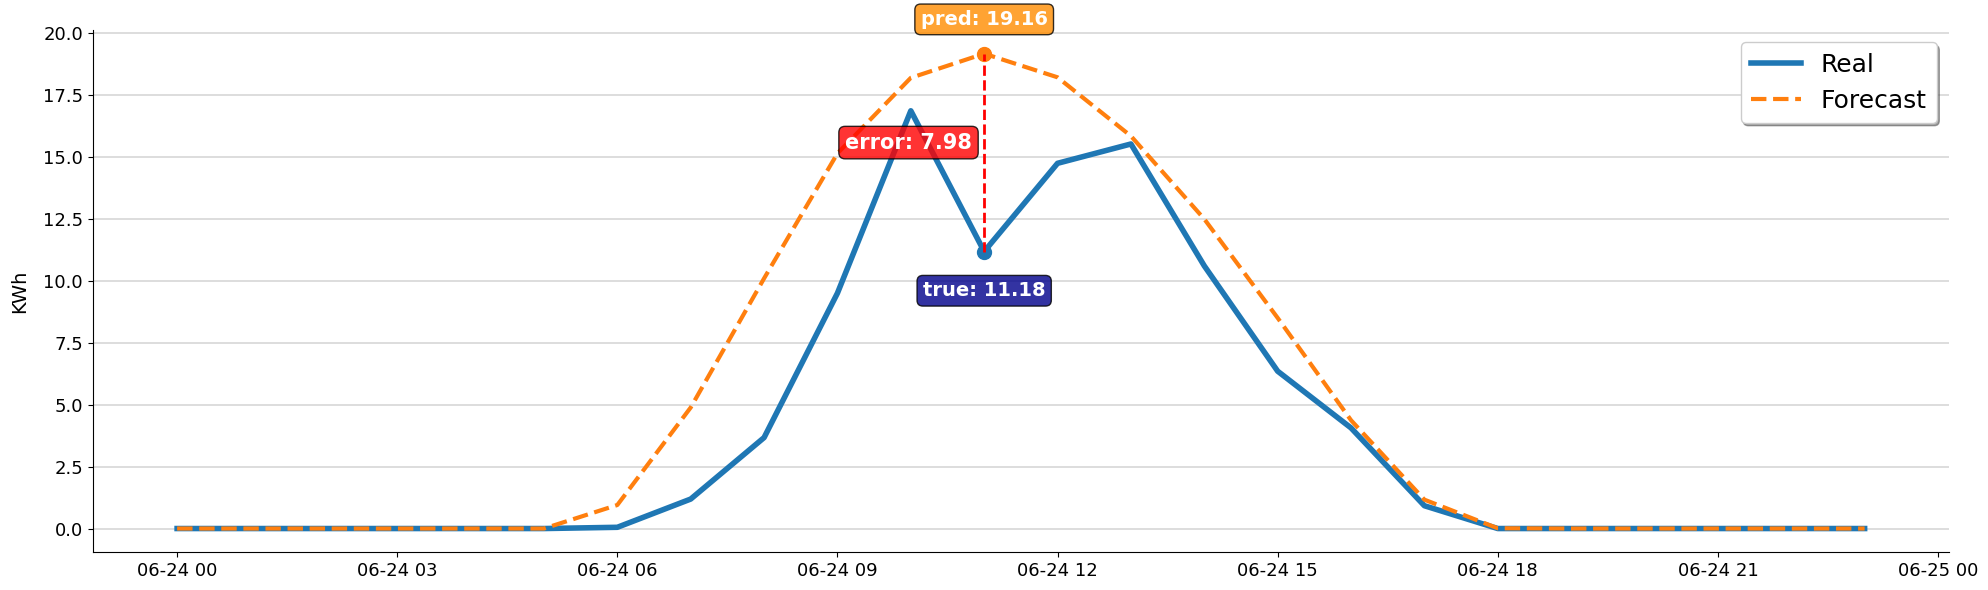

In [33]:
# plotar previsão e valor real para o dia 24 de Junho de 2024:
# Dia com grande erro de previsão devido oscilação na irradiação solar.

date_range = pd.date_range("2024-06-24", periods=24, freq="H", tz='America/Sao_Paulo')
df_filtered = fc_pred[fc_pred.index.isin(date_range)]

idx = df_filtered["abs_error"].idxmax()
point = df_filtered.loc[idx]

plt.figure(figsize=(20, 6))
plt.plot(df_filtered.index, df_filtered[TARGET], lw=4, color=color_test, label="Real")
plt.plot(df_filtered.index, df_filtered["y_pred"], lw=3, ls="--", color=color_forecast, label="Forecast")
plt.scatter(point.name, point[TARGET], color=color_test, s=100)
plt.scatter(point.name, point["y_pred"], color=color_forecast, s=100)
plt.vlines(point.name, point[TARGET], point["y_pred"], color="red", lw=2, linestyle="--")

plt.text(
    point.name,
    point[TARGET] - 1.2,
    f"true: {point[TARGET]:.2f}",
    ha="center",
    va="top",
    fontsize=14,
    color="white",
    fontweight="bold",
    bbox=dict(boxstyle="round", pad=.3, facecolor=dark_blue, alpha=0.8),
)

plt.text(
    point.name,
    point["y_pred"] + 1,
    f"pred: {point['y_pred']:.2f}",
    ha="center",
    va="bottom",
    fontsize=14,
    color="white",
    fontweight="bold",
    bbox=dict(boxstyle="round", pad=.3, facecolor=dark_orange, alpha=0.8),
)

plt.text(
    point.name - pd.DateOffset(minutes=10),
    (point[TARGET] + point['y_pred']) / 2,
    f"error: {point['abs_error']:.2f}",
    ha="right",
    va="bottom",
    fontsize=15,
    color="white",
    fontweight="bold",
    bbox=dict(boxstyle="round", pad=.3, facecolor="red", alpha=0.8),
)

# plt.title(f"Previsão de energia ({df_filtered.index.date.min()}) - Naive Median", fontsize=18, pad=30)
plt.xlabel("")
plt.ylabel("KWh", fontsize=14, labelpad=10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(axis="y", alpha=0.5, linewidth=1.2)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(
    fontsize=18,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
plt.tight_layout()
if SAVE_PLOT:
    plt.savefig("../figures/naive/forecast_error_24_10_24.pdf", dpi=300)
    plt.savefig("../figures/naive/forecast_error_24_10_24.svg", dpi=300)
plt.show()
